In [1]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
sys.path.append("/n/home12/binxuwang/Github/DiT")
from diffusion import create_diffusion
from models import DiT
from stats_plot_utils import saveallforms, add_rectangles 
from repr_probe_lib import extract_features_DiT, train_pca_sgd_classifiers 
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

In [2]:
import os
from os.path import join
import torch 
import torch as th 
import torch.nn as nn
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


In [5]:
device = "cuda"

In [6]:
# abstract RAVEN dataset
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [7]:
DiT_configs = {
    "DiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "DiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    "DiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "DiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    "DiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "DiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    "DiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "DiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
}
class_dropout_prob = 1.0
num_classes = 0
model_cfg = DiT_configs["DiT_S_1"]
model_DiT = DiT(input_size=9,
            in_channels=3, **model_cfg,
            mlp_ratio=4.0,
            class_dropout_prob=class_dropout_prob,
            num_classes=num_classes,
            learn_sigma=True,)

In [8]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model_DiT.load_state_dict(state_dict["ema"])
model_DiT.to(device).eval();

In [9]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/representation_geom_kNN_one_shot"
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)

In [10]:
t_scalar = 25
fetcher = featureFetcher_module()
for i in (5, 8, 11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_DiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_DiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|          | 0/59 [00:00<?, ?it/s]

blocks5: torch.Size([120000, 81, 384])
blocks8: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


  0%|          | 0/20 [00:00<?, ?it/s]

blocks5: torch.Size([40000, 81, 384])
blocks8: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [11]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

### kNN small shot learning

In [22]:
try:
    import cudf, cuml
    import cupy as cp
    from cuml.neighbors import KNeighborsClassifier  
    # this is much faster than sklearn
    print("cuML installed, using cuML backend")
except:
    print("No cuML installed, using sklearn instead")
    from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neighbors import KNeighborsClassifier

cuML installed, using cuML backend


In [20]:
t_str = 25
ckpt_str = "ckpt1000000EMA"
dimred_str = "avgtoken"
# Initialize the classifier
layer_str = "blocks11"
feat_train = feature_avg_col[layer_str].cpu().numpy()
feat_test = feature_avg_col_test[layer_str].cpu().numpy()
kNN_k = 10
prediction_col = {}
for kNN_k in (1, 3, 5, 10, 25, 50, 75, 100):
    knn = KNeighborsClassifier(n_neighbors=kNN_k, metric="cosine")
    # Train the classifier
    knn.fit(feat_train, y_train.numpy())
    # Predict
    predictions = knn.predict(feat_test)
    # print("Predictions (scikit-learn):", predictions)
    acc = (predictions == y_test.numpy()).mean()
    print(f"{layer_str} kNN {kNN_k} Accuracy: {acc}")
    prediction_col[(layer_str, kNN_k)] = {"predictions": predictions, "accuracy": acc}
pkl.dump(prediction_col, open(join(figexpdir, f"kNN_prediction_col_t{t_str}_{dimred_str}_{ckpt_str}_cosine.pkl"), "wb"))

blocks11 kNN 1 Accuracy: 0.74115
blocks11 kNN 3 Accuracy: 0.7633
blocks11 kNN 5 Accuracy: 0.7866
blocks11 kNN 10 Accuracy: 0.80725
blocks11 kNN 25 Accuracy: 0.830625
blocks11 kNN 50 Accuracy: 0.838425
blocks11 kNN 75 Accuracy: 0.8376
blocks11 kNN 100 Accuracy: 0.8379


In [23]:
t_str = 25
ckpt_str = "ckpt1000000EMA"
dimred_str = "avgtoken"
# Initialize the classifier
layer_str = "blocks11"
feat_train = feature_avg_col[layer_str].cpu().numpy()
feat_test = feature_avg_col_test[layer_str].cpu().numpy()
kNN_k = 10
prediction_col = {}
for kNN_k in (1, 3, 5, 10, 25, 50, 75, 100):
    knn = KNeighborsClassifier(n_neighbors=kNN_k, metric='euclidean')
    # Train the classifier
    knn.fit(feat_train, y_train.numpy())
    # Predict
    predictions = knn.predict(feat_test)
    # print("Predictions (scikit-learn):", predictions)
    acc = (predictions == y_test.numpy()).mean()
    print(f"{layer_str} kNN {kNN_k} Accuracy: {acc}")
    prediction_col[(layer_str, kNN_k)] = {"predictions": predictions, "accuracy": acc}
pkl.dump(prediction_col, open(join(figexpdir, f"kNN_prediction_col_t{t_str}_{dimred_str}_{ckpt_str}_euclidean.pkl"), "wb"))


blocks11 kNN 1 Accuracy: 0.738025
blocks11 kNN 3 Accuracy: 0.75785
blocks11 kNN 5 Accuracy: 0.7822
blocks11 kNN 10 Accuracy: 0.801675
blocks11 kNN 25 Accuracy: 0.825
blocks11 kNN 50 Accuracy: 0.83255
blocks11 kNN 75 Accuracy: 0.835
blocks11 kNN 100 Accuracy: 0.833725


### Two class binary classification accuracy

In [25]:
def generate_batches_parallel_torch(n, k, K):
    # Create an array of indices
    # indices = torch.arange(n)
    # Preallocate memory for batches
    batches = torch.zeros((K, k), dtype=torch.long)
    for i in range(K):
        # Shuffle indices and pick the first k indices for each batch
        batches[i] = torch.randperm(n)[:k]#indices[]
    return batches

In [61]:
import torch

def cosine_distance(featmat1, featmat2, dim=-1):
    # allow broadcasting
    # e.g. featmat1.shape = (batch, K, dim), featmat2.shape = (batch, 1, dim)
    # output shape = (batch, K)
    # Compute the dot product for each pair of vectors
    dot_product = torch.sum(featmat1 * featmat2, dim=dim)
    # Compute the norms of each vector
    norm1 = torch.norm(featmat1, dim=dim)
    norm2 = torch.norm(featmat2, dim=dim)
    # Compute the cosine similarity
    cosine_similarity = dot_product / (norm1 * norm2 + 1e-8)  # Add epsilon to avoid division by zero
    # Compute the cosine distance
    cosine_distance = 1 - cosine_similarity
    return cosine_distance


def euclidean_distance(featmat1, featmat2, dim=-1):
    # allow broadcasting
    # e.g. featmat1.shape = (batch, K, dim), featmat2.shape = (batch, 1, dim)
    # output shape = (batch, K)
    return ((featmat1 - featmat2)**2).sum(dim=dim)


In [68]:
# sweep class1 [pos], class2 [neg], class1 != class2
# get k+1 vectors for class1 and k vectors for class2. 
# evaluate the accuracy of k-NN classifier. compute the distance of k+1 vectors to 2*k vectors in positive and negative class. 
# Count for the class with the most votes. 
device = "cuda"
kNN_k = 50
train_sample_num = 3000
test_sample_num = 1000
test_case_num = 1000
metric = "cosine"
layer_str = "blocks11"
feat_train_perclass = feature_avg_col[layer_str].reshape(40, train_sample_num, -1).to(device)
feat_test_perclass = feature_avg_col_test[layer_str].reshape(40, test_sample_num, -1).to(device)
acc_mat = np.zeros((40, 40))
for class1 in range(40):
    for class2 in range(40):
        if class1 == class2:
            acc_mat[class1, class2] = np.nan
            continue
        # print(f"Class1: {class1}, Class2: {class2}")
        feat_train_pos = feat_train_perclass[class1, :, :]
        feat_train_neg = feat_train_perclass[class2, :, :]
        feat_test_pos = feat_test_perclass[class1, :, :]
        # random samples from train_pos with `test_case_num`, kNN_k 
        # get k+1 vectors for class1 and k vectors for class2. 
        batches_pos = torch.randint(train_sample_num, (test_case_num, kNN_k))
        batches_neg = torch.randint(train_sample_num, (test_case_num, kNN_k))
        batches_pos_test = torch.randint(test_sample_num, (test_case_num, 1))
        vectors_pos = feat_train_pos[batches_pos, :] # (test_case_num, kNN_k, dim)
        vectors_neg = feat_train_neg[batches_neg, :] # (test_case_num, kNN_k, dim)
        vectors_pos_test = feat_test_pos[batches_pos_test, :] # (test_case_num, dim)
        # compute the distance of vectors_pos_test to vectors_pos and vectors_neg
        # dist_pos = euclidean_distance(vectors_pos_test, vectors_pos, dim=-1)
        # dist_neg = euclidean_distance(vectors_pos_test, vectors_neg, dim=-1)
        # cosine distance
        if metric == "cosine":
            dist_pos = cosine_distance(vectors_pos_test, vectors_pos, dim=-1) # (test_case_num, kNN_k)
            dist_neg = cosine_distance(vectors_pos_test, vectors_neg, dim=-1) # (test_case_num, kNN_k)
        elif metric == "euclidean":
            dist_pos = euclidean_distance(vectors_pos_test, vectors_pos, dim=-1) # (test_case_num, kNN_k)
            dist_neg = euclidean_distance(vectors_pos_test, vectors_neg, dim=-1) # (test_case_num, kNN_k)
        dist_cat = th.cat([dist_pos, dist_neg], dim=-1) # (test_case_num, 2*kNN_k)
        # sort the distance, get topk smallest distance
        dist_topk, dist_topk_idx = th.topk(dist_cat, k=kNN_k, dim=-1, largest=False) # (test_case_num, kNN_k)
        # count the class with the most votes
        pos_votes = (dist_topk_idx < kNN_k).sum(dim=-1) # number of votes for class1
        pred = pos_votes > (kNN_k/2) # majority vote
        # pred = (dist_pos < dist_neg).sum(dim=1)
        # acc = pred.float().mean()
        acc = pred.float().mean()
        acc_mat[class1, class2] = acc
        # print(f"Class1: {class1}, Class2: {class2}, Accuracy: {acc}")
np.fill_diagonal(acc_mat, np.nan)
plt.figure(figsize=(15,15))
sns.heatmap(100*acc_mat, annot=True, fmt=".0f", cmap="YlGnBu")
plt.ylabel("Class 1 [pos]")
plt.xlabel("Class 2 [neg]")
plt.title(f"{layer_str} kNN {kNN_k} Accuracy Metric={metric}")
saveallforms(figexpdir, f"kNN_accuracy_heatmap_t{t_str}_{dimred_str}_{ckpt_str}_k{kNN_k}_binary_clsf_{metric}")

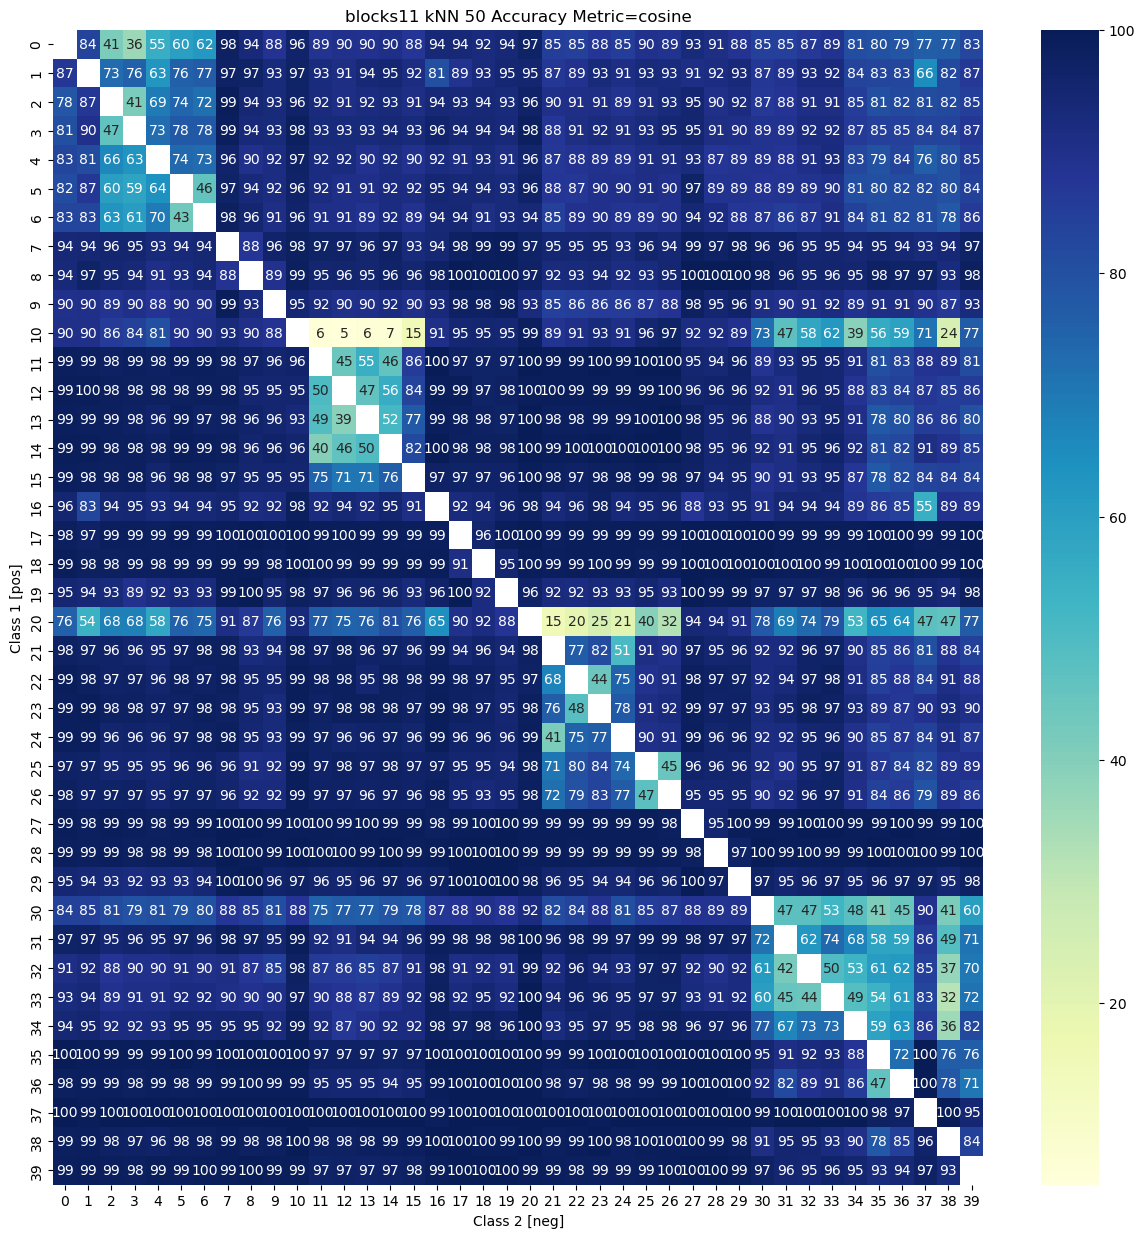

In [69]:
plt.figure(figsize=(15,15))
sns.heatmap(100*acc_mat, annot=True, fmt=".0f", cmap="YlGnBu")
plt.ylabel("Class 1 [pos]")
plt.xlabel("Class 2 [neg]")
plt.title(f"{layer_str} kNN {kNN_k} Accuracy Metric={metric}")
saveallforms(figexpdir, f"kNN_accuracy_heatmap_t{t_str}_{dimred_str}_{ckpt_str}_k{kNN_k}_binary_clsf_{metric}")

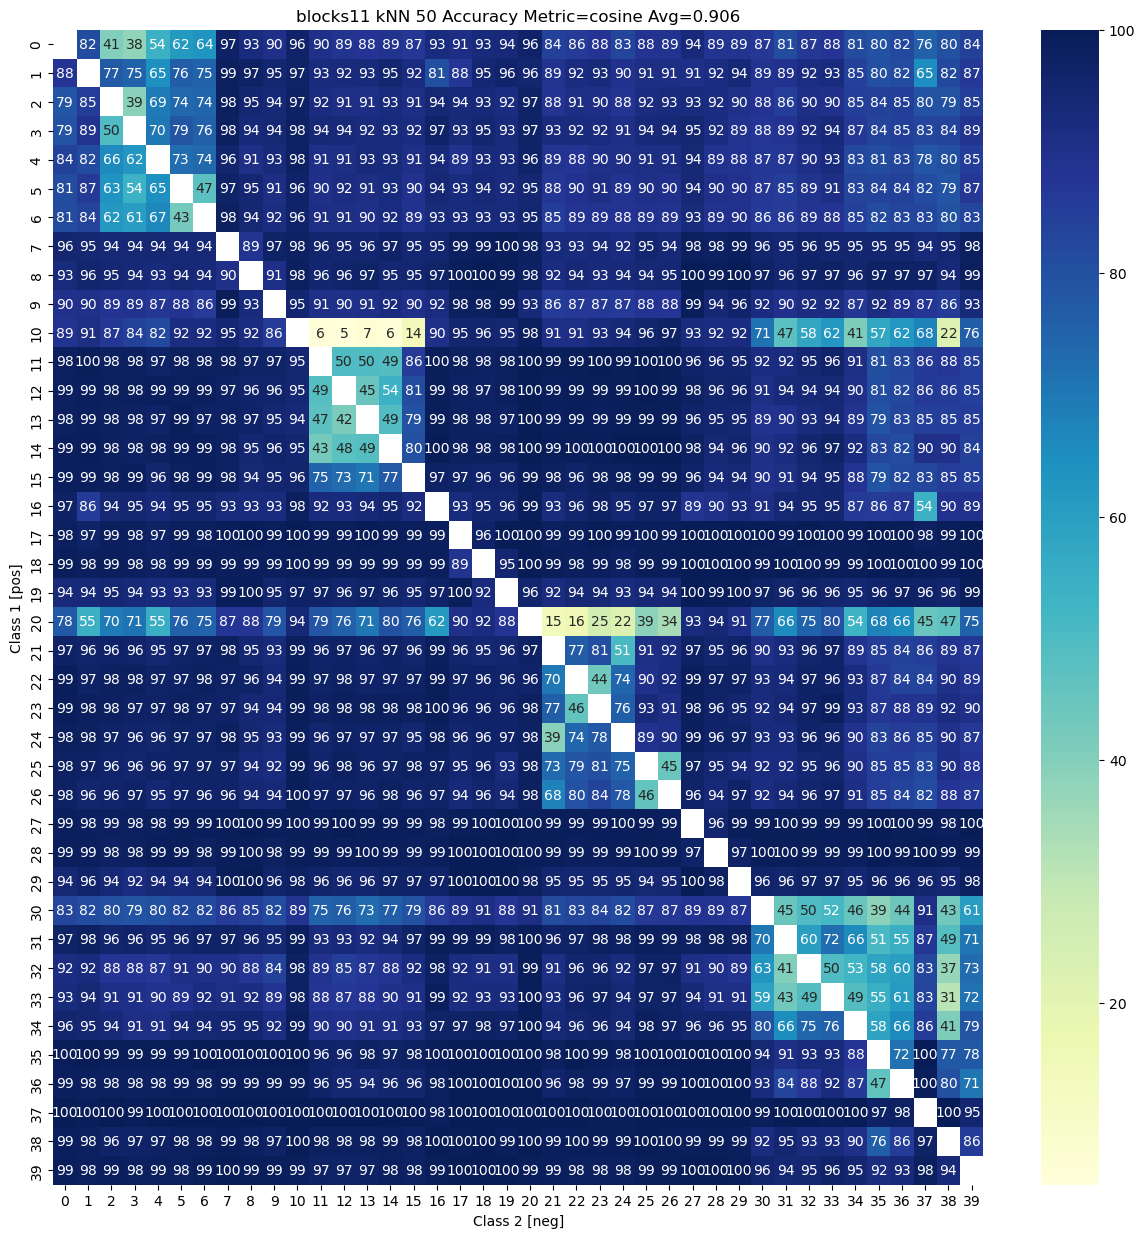

In [73]:
# sweep class1 [pos], class2 [neg], class1 != class2
# get k+1 vectors for class1 and k vectors for class2. 
# evaluate the accuracy of k-NN classifier. compute the distance of k+1 vectors to 2*k vectors in positive and negative class. 
# Count for the class with the most votes. 
device = "cuda"
train_sample_num = 3000
test_sample_num = 1000
test_case_num = 1000
kNN_k = 50
metric = "cosine"
layer_str = "blocks11"
feat_train_perclass = feature_avg_col[layer_str].reshape(40, train_sample_num, -1).to(device)
feat_test_perclass = feature_avg_col_test[layer_str].reshape(40, test_sample_num, -1).to(device)
acc_mat = np.zeros((40, 40))
for class1 in range(40):
    for class2 in range(40):
        if class1 == class2:
            acc_mat[class1, class2] = np.nan
            continue
        # print(f"Class1: {class1}, Class2: {class2}")
        feat_train_pos = feat_train_perclass[class1, :, :]
        feat_train_neg = feat_train_perclass[class2, :, :]
        feat_test_pos = feat_test_perclass[class1, :, :]
        # random samples from train_pos with `test_case_num`, kNN_k 
        # get k+1 vectors for class1 and k vectors for class2. 
        batches_pos = torch.randint(train_sample_num, (test_case_num, kNN_k))
        batches_neg = torch.randint(train_sample_num, (test_case_num, kNN_k))
        batches_pos_test = torch.randint(test_sample_num, (test_case_num, 1))
        vectors_pos = feat_train_pos[batches_pos, :] # (test_case_num, kNN_k, dim)
        vectors_neg = feat_train_neg[batches_neg, :] # (test_case_num, kNN_k, dim)
        vectors_pos_test = feat_test_pos[batches_pos_test, :] # (test_case_num, dim)
        # compute the distance of vectors_pos_test to vectors_pos and vectors_neg
        if metric == "cosine":
            dist_pos = cosine_distance(vectors_pos_test, vectors_pos, dim=-1) # (test_case_num, kNN_k)
            dist_neg = cosine_distance(vectors_pos_test, vectors_neg, dim=-1) # (test_case_num, kNN_k)
        elif metric == "euclidean":
            dist_pos = euclidean_distance(vectors_pos_test, vectors_pos, dim=-1) # (test_case_num, kNN_k)
            dist_neg = euclidean_distance(vectors_pos_test, vectors_neg, dim=-1) # (test_case_num, kNN_k)
        dist_cat = th.cat([dist_pos, dist_neg], dim=-1) # (test_case_num, 2*kNN_k)
        # sort the distance, get topk smallest distance
        dist_topk, dist_topk_idx = th.topk(dist_cat, k=kNN_k, dim=-1, largest=False) # (test_case_num, kNN_k)
        # count the class with the most votes
        pos_votes = (dist_topk_idx < kNN_k).sum(dim=-1) # number of votes for class1
        pred = pos_votes > (kNN_k/2) # majority vote
        # pred = (dist_pos < dist_neg).sum(dim=1)
        # acc = pred.float().mean()
        acc = pred.float().mean()
        acc_mat[class1, class2] = acc
        # print(f"Class1: {class1}, Class2: {class2}, Accuracy: {acc}")
np.fill_diagonal(acc_mat, np.nan)
acc_mat_avg = np.nanmean(acc_mat, axis=0)
# compute average accuracy, without nan
plt.figure(figsize=(15,15))
sns.heatmap(100*acc_mat, annot=True, fmt=".0f", cmap="YlGnBu")
plt.ylabel("Class 1 [pos]")
plt.xlabel("Class 2 [neg]")
plt.title(f"{layer_str} kNN {kNN_k} Accuracy Metric={metric} Avg={acc_mat_avg.mean():.3f}")
saveallforms(figexpdir, f"kNN_accuracy_heatmap_t{t_str}_{dimred_str}_{ckpt_str}_{layer_str}_k{kNN_k}_binary_clsf_{metric}")

### Sweep across layer, metric and kNN

In [76]:
# sweep class1 [pos], class2 [neg], class1 != class2
# get k+1 vectors for class1 and k vectors for class2. 
# evaluate the accuracy of k-NN classifier. compute the distance of k+1 vectors to 2*k vectors in positive and negative class. 
# Count for the class with the most votes. 
device = "cuda"
train_sample_num = 3000
test_sample_num = 1000
test_case_num = 1000
for layer_str in ("blocks11", "blocks8", "blocks5", ):
    feat_train_perclass = feature_avg_col[layer_str].reshape(40, train_sample_num, -1).to(device)
    feat_test_perclass = feature_avg_col_test[layer_str].reshape(40, test_sample_num, -1).to(device)
    for metric in ("cosine", "euclidean"):
        for kNN_k in (1, 3, 5, 10, 25, 50, 75, 100):
            acc_mat = np.zeros((40, 40))
            for class1 in range(40):
                for class2 in range(40):
                    if class1 == class2:
                        acc_mat[class1, class2] = np.nan
                        continue
                    # print(f"Class1: {class1}, Class2: {class2}")
                    feat_train_pos = feat_train_perclass[class1, :, :]
                    feat_train_neg = feat_train_perclass[class2, :, :]
                    feat_test_pos = feat_test_perclass[class1, :, :]
                    # random samples from train_pos with `test_case_num`, kNN_k 
                    # get k+1 vectors for class1 and k vectors for class2. 
                    batches_pos = torch.randint(train_sample_num, (test_case_num, kNN_k))
                    batches_neg = torch.randint(train_sample_num, (test_case_num, kNN_k))
                    batches_pos_test = torch.randint(test_sample_num, (test_case_num, 1))
                    vectors_pos = feat_train_pos[batches_pos, :] # (test_case_num, kNN_k, dim)
                    vectors_neg = feat_train_neg[batches_neg, :] # (test_case_num, kNN_k, dim)
                    vectors_pos_test = feat_test_pos[batches_pos_test, :] # (test_case_num, dim)
                    # compute the distance of vectors_pos_test to vectors_pos and vectors_neg
                    if metric == "cosine":
                        dist_pos = cosine_distance(vectors_pos_test, vectors_pos, dim=-1) # (test_case_num, kNN_k)
                        dist_neg = cosine_distance(vectors_pos_test, vectors_neg, dim=-1) # (test_case_num, kNN_k)
                    elif metric == "euclidean":
                        dist_pos = euclidean_distance(vectors_pos_test, vectors_pos, dim=-1) # (test_case_num, kNN_k)
                        dist_neg = euclidean_distance(vectors_pos_test, vectors_neg, dim=-1) # (test_case_num, kNN_k)
                    else:
                        raise ValueError(f"Metric {metric} not supported")
                    dist_cat = th.cat([dist_pos, dist_neg], dim=-1) # (test_case_num, 2*kNN_k)
                    # sort the distance, get topk smallest distance
                    dist_topk, dist_topk_idx = th.topk(dist_cat, k=kNN_k, dim=-1, largest=False) # (test_case_num, kNN_k)
                    # count the class with the most votes
                    pos_votes = (dist_topk_idx < kNN_k).sum(dim=-1) # number of votes for class1
                    pred = pos_votes > (kNN_k/2) # majority vote
                    # pred = (dist_pos < dist_neg).sum(dim=1)
                    # acc = pred.float().mean()
                    acc = pred.float().mean()
                    acc_mat[class1, class2] = acc
                    # print(f"Class1: {class1}, Class2: {class2}, Accuracy: {acc}")
            np.fill_diagonal(acc_mat, np.nan)
            acc_mat_avg = np.nanmean(acc_mat, axis=0)
            print(f"{layer_str} kNN {kNN_k} Dist.Metric={metric} Avg Acc={acc_mat_avg.mean():.3f}")
            np.save(join(figexpdir, f"kNN_accuracy_mat_t{t_str}_{dimred_str}_{ckpt_str}_{layer_str}_k{kNN_k}_binary_clsf_{metric}.npy"), acc_mat)
            # compute average accuracy, without nan
            plt.figure(figsize=(15,15))
            sns.heatmap(100*acc_mat, annot=True, fmt=".0f", cmap="YlGnBu")
            plt.ylabel("Class 1 [pos]")
            plt.xlabel("Class 2 [neg]")
            plt.title(f"{layer_str} kNN {kNN_k} Accuracy Metric={metric} Avg={acc_mat_avg.mean():.3f}")
            saveallforms(figexpdir, f"kNN_accuracy_heatmap_t{t_str}_{dimred_str}_{ckpt_str}_{layer_str}_k{kNN_k}_binary_clsf_{metric}")
            plt.close("all")

blocks11 kNN 1 Dist.Metric=cosine Avg Acc=0.786
blocks11 kNN 3 Dist.Metric=cosine Avg Acc=0.834
blocks11 kNN 5 Dist.Metric=cosine Avg Acc=0.857
blocks11 kNN 10 Dist.Metric=cosine Avg Acc=0.826
blocks11 kNN 25 Dist.Metric=cosine Avg Acc=0.906
blocks11 kNN 50 Dist.Metric=cosine Avg Acc=0.906
blocks11 kNN 75 Dist.Metric=cosine Avg Acc=0.922
blocks11 kNN 100 Dist.Metric=cosine Avg Acc=0.918
blocks11 kNN 1 Dist.Metric=euclidean Avg Acc=0.770
blocks11 kNN 3 Dist.Metric=euclidean Avg Acc=0.815
blocks11 kNN 5 Dist.Metric=euclidean Avg Acc=0.837
blocks11 kNN 10 Dist.Metric=euclidean Avg Acc=0.800
blocks11 kNN 25 Dist.Metric=euclidean Avg Acc=0.889
blocks11 kNN 50 Dist.Metric=euclidean Avg Acc=0.888
blocks11 kNN 75 Dist.Metric=euclidean Avg Acc=0.906
blocks11 kNN 100 Dist.Metric=euclidean Avg Acc=0.902
blocks8 kNN 1 Dist.Metric=cosine Avg Acc=0.772
blocks8 kNN 3 Dist.Metric=cosine Avg Acc=0.820
blocks8 kNN 5 Dist.Metric=cosine Avg Acc=0.844
blocks8 kNN 10 Dist.Metric=cosine Avg Acc=0.810
blocks8

### Synopsis across kNN and layer

In [77]:
figexpdir
acc_syn_df_col = []
for layer_str in ("blocks11", "blocks8", "blocks5", ):
    for metric in ("cosine", "euclidean"):
        for kNN_k in (1, 3, 5, 10, 25, 50, 75, 100):
            acc_mat = np.load(join(figexpdir, f"kNN_accuracy_mat_t{t_str}_{dimred_str}_{ckpt_str}_{layer_str}_k{kNN_k}_binary_clsf_{metric}.npy"))
            # acc_mat_avg = np.nanmean(acc_mat, axis=0)
            acc_mat_avg_mean = np.nanmean(acc_mat)
            acc_syn_df_col.append({
                "Layer": layer_str,
                "Metric": metric,
                "kNN_k": kNN_k,
                "Avg_Acc": acc_mat_avg_mean
            })
acc_syn_df_all = pd.DataFrame(acc_syn_df_col)
# acc_syn_df_all.to_csv(join(figexpdir, f"kNN_accuracy_syn_df_t{t_str}_{dimred_str}_{ckpt_str}.csv"), index=False)


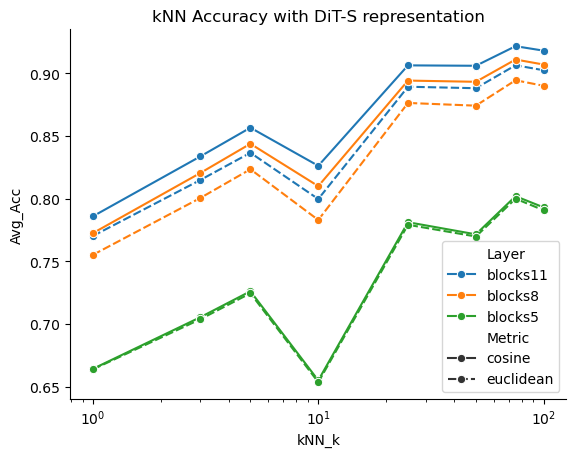

In [80]:
sns.lineplot(data=acc_syn_df_all, x="kNN_k", y="Avg_Acc", hue="Layer", marker="o", style="Metric")
plt.xscale("log")
plt.title(f"kNN Accuracy with DiT-S representation")
saveallforms(figexpdir, f"kNN_accuracy_syn_df_t{t_str}_{dimred_str}_{ckpt_str}")
# plt.close("all")

### Dimension reduction guided by Linear Classifier

In [81]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train, y_test,
    PC_dim=None, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=1000, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8777, Accuracy: 0.0273
Epoch [1000/5000], Loss: 0.1364, Accuracy: 0.9581
Test Accuracy: 0.9450
Epoch [2000/5000], Loss: 0.1037, Accuracy: 0.9666
Test Accuracy: 0.9501
Epoch [3000/5000], Loss: 0.0887, Accuracy: 0.9710
Test Accuracy: 0.9524
Epoch [4000/5000], Loss: 0.0794, Accuracy: 0.9732
Test Accuracy: 0.9530
Epoch [5000/5000], Loss: 0.0729, Accuracy: 0.9749
Test Accuracy: 0.9526
Test Accuracy: 0.9526
Layer blocks5 - PCA time: 0.05s, PCA transform time: 0.14s, Training time: 32.86s
Processing layer: blocks8
Epoch [1/5000], Loss: 3.8523, Accuracy: 0.0274
Epoch [1000/5000], Loss: 0.0139, Accuracy: 0.9982
Test Accuracy: 0.9953
Epoch [2000/5000], Loss: 0.0066, Accuracy: 0.9994
Test Accuracy: 0.9958
Epoch [3000/5000], Loss: 0.0038, Accuracy: 0.9997
Test Accuracy: 0.9958
Epoch [4000/5000], Loss: 0.0024, Accuracy: 0.9999
Test Accuracy: 0.9959
Epoch [5000/5000], Loss: 0.0015, Accuracy: 0.9999
Test Accuracy: 0.9960
Test Accuracy: 0.9960
Layer bl

### kNN in linear dimension reduced space

In [112]:
def eval_kNN_classifier(feat_train, feat_test, y_train, y_test, kNN_ks=(1, 3, 5, 10, 25, 50, 75, 100), metric="cosine"):
    if isinstance(feat_train, th.Tensor):
        feat_train = feat_train.cpu().numpy()
    if isinstance(feat_test, th.Tensor):
        feat_test = feat_test.cpu().numpy()
    prediction_col = {}
    for kNN_k in kNN_ks:
        knn = KNeighborsClassifier(n_neighbors=kNN_k, metric=metric)
        # Train the classifier
        knn.fit(feat_train, y_train.numpy())
        # Predict
        predictions = knn.predict(feat_test)
        # print("Predictions (scikit-learn):", predictions)
        acc = (predictions == y_test.numpy()).mean()
        print(f"kNN {kNN_k} Accuracy: {acc}")
        prediction_col[kNN_k] = {"predictions": predictions, "accuracy": acc}
    return prediction_col

### dimension reduction with its own linear reg subspace

In [91]:
layer_str = "blocks11"
weight = model_PCA_col[layer_str].fc.weight.detach()
bias = model_PCA_col[layer_str].fc.bias.detach()
sample_mean = PC_proj_col[layer_str]['mean'].detach().to(device)
sample_std = PC_proj_col[layer_str]['std'].detach().to(device)

feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)

In [123]:
print("Use the full linear classifier weight and bias (with mean and std normalization)")
feat_train_avg_proj = (feat_train_avg - sample_mean) / sample_std @ weight.T + bias
feat_test_avg_proj = (feat_test_avg - sample_mean) / sample_std @ weight.T + bias
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use the full linear classifier weight and bias (with mean and std normalization)
kNN 1 Accuracy: 0.992825
kNN 3 Accuracy: 0.9948
kNN 5 Accuracy: 0.995375
kNN 10 Accuracy: 0.9952
kNN 25 Accuracy: 0.995
kNN 50 Accuracy: 0.99455
kNN 75 Accuracy: 0.994325
kNN 100 Accuracy: 0.994025


In [124]:
print("Use the linear classifier weight, no bias (with mean and std normalization)")
feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
feat_train_avg_proj = (feat_train_avg - sample_mean) / sample_std @ weight.T
feat_test_avg_proj = (feat_test_avg - sample_mean) / sample_std @ weight.T
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use the linear classifier weight, no bias (with mean and std normalization)
kNN 1 Accuracy: 0.992725
kNN 3 Accuracy: 0.9949
kNN 5 Accuracy: 0.995325
kNN 10 Accuracy: 0.99525
kNN 25 Accuracy: 0.995025
kNN 50 Accuracy: 0.994625
kNN 75 Accuracy: 0.994325
kNN 100 Accuracy: 0.994325


In [125]:
print("Use only the orthogonal projection of linear classifier weight (with mean and std normalization)")
feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
W_U, W_S, W_V = th.svd(weight)
print(W_U.shape, W_S.shape, W_V.shape)
feat_train_avg_proj = (feat_train_avg - sample_mean) / sample_std @ W_V  # + bias
feat_test_avg_proj = (feat_test_avg - sample_mean) / sample_std @ W_V  # + bias
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use only the orthogonal projection of linear classifier weight (with mean and std normalization)
torch.Size([40, 40]) torch.Size([40]) torch.Size([384, 40])
kNN 1 Accuracy: 0.957
kNN 3 Accuracy: 0.968375
kNN 5 Accuracy: 0.973875
kNN 10 Accuracy: 0.978275
kNN 25 Accuracy: 0.981225
kNN 50 Accuracy: 0.981425
kNN 75 Accuracy: 0.980725
kNN 100 Accuracy: 0.98025


In [126]:
print("Use only the orthogonal projection + scaling of linear classifier weight (with mean and std normalization)")
feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
W_U, W_S, W_V = th.svd(weight)
print(W_U.shape, W_S.shape, W_V.shape)
feat_train_avg_proj = (feat_train_avg - sample_mean) / sample_std @ W_V * W_S # + bias
feat_test_avg_proj = (feat_test_avg - sample_mean) / sample_std @ W_V * W_S # + bias
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use only the orthogonal projection + scaling of linear classifier weight (with mean and std normalization)
torch.Size([40, 40]) torch.Size([40]) torch.Size([384, 40])
kNN 1 Accuracy: 0.992725
kNN 3 Accuracy: 0.9949
kNN 5 Accuracy: 0.995325
kNN 10 Accuracy: 0.99525
kNN 25 Accuracy: 0.995025
kNN 50 Accuracy: 0.994625
kNN 75 Accuracy: 0.994325
kNN 100 Accuracy: 0.994325


In [150]:
print("Use project out the linear classifier weight, scaling of linear classifier weight (with mean and std normalization)")
feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
W_U_full, W_S_full, W_V_full = th.svd(weight, some=False)
print(W_U_full.shape, W_S_full.shape, W_V_full.shape)
feat_train_avg_proj = (feat_train_avg - sample_mean) / sample_std @ W_V_full[:, 40:]  # + bias
feat_test_avg_proj = (feat_test_avg - sample_mean) / sample_std @ W_V_full[:, 40:]  # + bias
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use project out the linear classifier weight, scaling of linear classifier weight (with mean and std normalization)
torch.Size([40, 40]) torch.Size([40]) torch.Size([384, 384])
kNN 1 Accuracy: 0.659375
kNN 3 Accuracy: 0.66665
kNN 5 Accuracy: 0.700925
kNN 10 Accuracy: 0.728775
kNN 25 Accuracy: 0.751375
kNN 50 Accuracy: 0.759475
kNN 75 Accuracy: 0.761575
kNN 100 Accuracy: 0.759975


In [127]:
print("Use only the orthogonal projection + scaling of linear classifier weight (with std normalization, no centering)")

feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
W_U, W_S, W_V = th.svd(weight)
print(W_U.shape, W_S.shape, W_V.shape)
feat_train_avg_proj = (feat_train_avg ) / sample_std @ W_V * W_S # + bias
feat_test_avg_proj = (feat_test_avg ) / sample_std @ W_V * W_S # + bias
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use only the orthogonal projection + scaling of linear classifier weight (with std normalization, no centering)
torch.Size([40, 40]) torch.Size([40]) torch.Size([384, 40])
kNN 1 Accuracy: 0.991125
kNN 3 Accuracy: 0.993875
kNN 5 Accuracy: 0.994325
kNN 10 Accuracy: 0.99465
kNN 25 Accuracy: 0.9943
kNN 50 Accuracy: 0.9938
kNN 75 Accuracy: 0.993575
kNN 100 Accuracy: 0.993225


In [128]:
print("Use only the orthogonal projection + scaling of linear classifier weight (no std normalization, no centering)")

feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
W_U, W_S, W_V = th.svd(weight)
print(W_U.shape, W_S.shape, W_V.shape)
feat_train_avg_proj = (feat_train_avg ) @ W_V * W_S # + bias
feat_test_avg_proj = (feat_test_avg ) @ W_V * W_S # + bias
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use only the orthogonal projection + scaling of linear classifier weight (no std normalization, no centering)
torch.Size([40, 40]) torch.Size([40]) torch.Size([384, 40])
kNN 1 Accuracy: 0.95755
kNN 3 Accuracy: 0.96795
kNN 5 Accuracy: 0.97145
kNN 10 Accuracy: 0.973375
kNN 25 Accuracy: 0.972875
kNN 50 Accuracy: 0.97065
kNN 75 Accuracy: 0.969725
kNN 100 Accuracy: 0.968425


In [129]:
print("Use only the orthogonal projection of linear classifier weight (no std normalization, no centering)")
feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
W_U, W_S, W_V = th.svd(weight)
print(W_U.shape, W_S.shape, W_V.shape)
feat_train_avg_proj = (feat_train_avg ) @ W_V  # + bias
feat_test_avg_proj = (feat_test_avg ) @ W_V  # + bias
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use only the orthogonal projection of linear classifier weight (no std normalization, no centering)
torch.Size([40, 40]) torch.Size([40]) torch.Size([384, 40])
kNN 1 Accuracy: 0.925325
kNN 3 Accuracy: 0.94285
kNN 5 Accuracy: 0.95075
kNN 10 Accuracy: 0.956575
kNN 25 Accuracy: 0.9622
kNN 50 Accuracy: 0.96235
kNN 75 Accuracy: 0.960825
kNN 100 Accuracy: 0.960475


In [ ]:
# pkl.dump(prediction_col, open(join(figexpdir, f"kNN_prediction_col_t{t_str}_{dimred_str}_{ckpt_str}_cosine.pkl"), "wb"))

### Visualize the linear orthogonal projected representation

torch.Size([40, 40]) torch.Size([40]) torch.Size([384, 40])


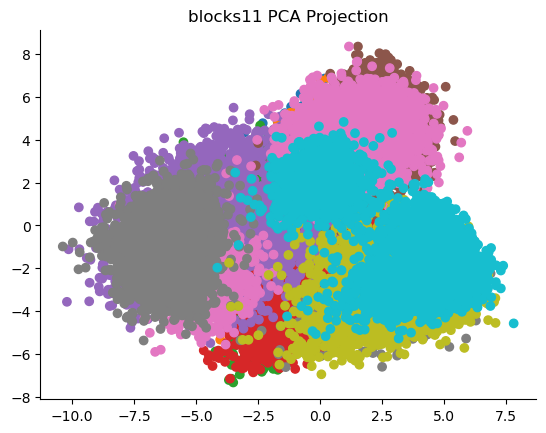

In [138]:
feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
W_U, W_S, W_V = th.svd(weight)
print(W_U.shape, W_S.shape, W_V.shape)
feat_train_avg_proj = (feat_train_avg - sample_mean) / sample_std @ W_V  # + bias
feat_test_avg_proj = (feat_test_avg - sample_mean) / sample_std @ W_V  # + bias

# visualize the projection in 2D
from cuml.decomposition import PCA
dimred_str = "PCA"
pca = PCA(n_components=2)
feat_train_avg_proj_2d = pca.fit_transform(feat_train_avg_proj)
feat_test_avg_proj_2d = pca.transform(feat_test_avg_proj).get()
plt.scatter(feat_test_avg_proj_2d[:, 0], feat_test_avg_proj_2d[:, 1], c=y_test, cmap="tab10")
plt.title(f"{layer_str} {dimred_str} Projection")
plt.show()


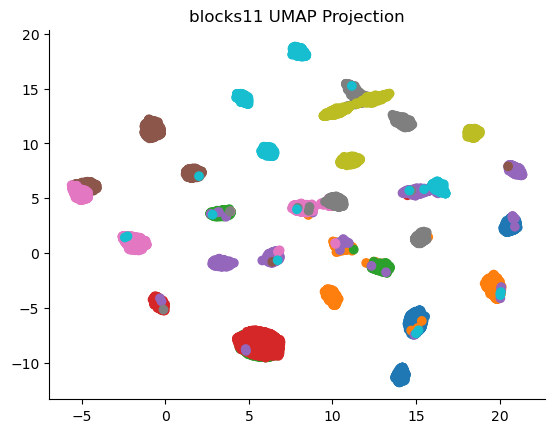

In [142]:
from umap import UMAP
dimred_str = "UMAP"
umap = UMAP(n_components=2)
# feat_train_avg_proj_2d = umap.fit_transform(feat_train_avg_proj.cpu().numpy())
feat_test_avg_proj_2d = umap.fit_transform(feat_test_avg_proj.cpu().numpy())
plt.scatter(feat_test_avg_proj_2d[:, 0], feat_test_avg_proj_2d[:, 1], c=y_test, cmap="tab10")
plt.title(f"{layer_str} {dimred_str} Projection")
plt.show()

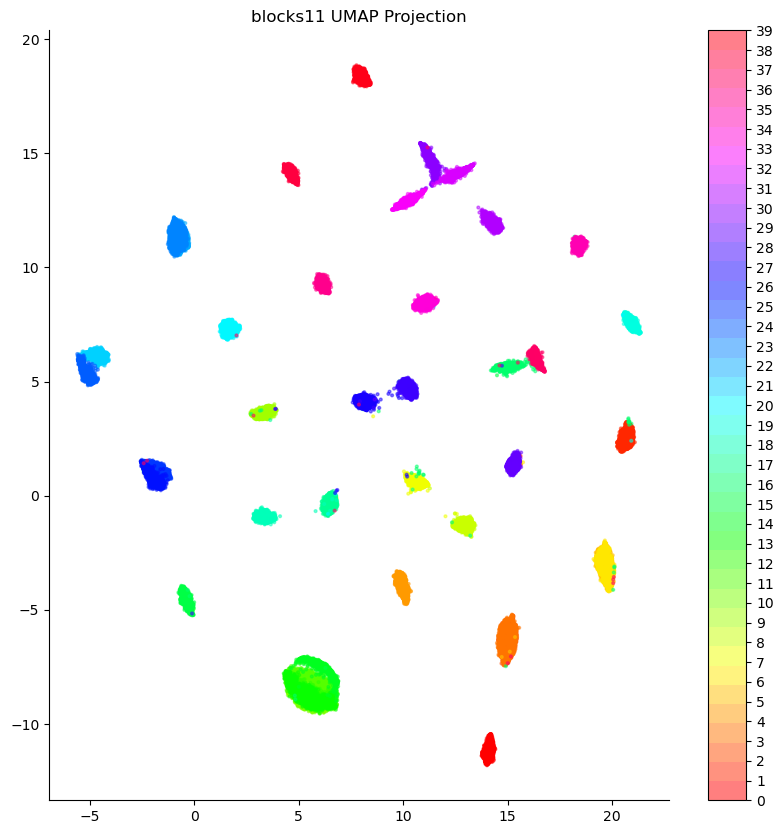

In [147]:
import matplotlib
cmap = matplotlib.colormaps["hsv"].resampled(40)  # Using HSV colormap for more distinct colors
plt.figure(figsize=(10,10))
plt.scatter(feat_test_avg_proj_2d[:, 0], feat_test_avg_proj_2d[:, 1], c=y_test, 
            cmap=cmap, alpha=0.5, s=4, marker="o")
plt.colorbar(ticks=np.arange(40), format="%d")
plt.title(f"{layer_str} {dimred_str} Projection")
plt.show()

### Dim reduction with linear readout weights across layers 

In [184]:
layer_str = "blocks8"
weight = model_PCA_col[layer_str].fc.weight.detach()
bias = model_PCA_col[layer_str].fc.bias.detach()
layer_str = "blocks11"
feat_train_avg = feature_avg_col[layer_str].to(device)
feat_test_avg = feature_avg_col_test[layer_str].to(device)
sample_mean = PC_proj_col[layer_str]['mean'].detach().to(device)
sample_std = PC_proj_col[layer_str]['std'].detach().to(device)

In [185]:
print("Use the full linear classifier weight and bias (with mean and std normalization)")
feat_train_avg_proj = (feat_train_avg - sample_mean) / sample_std @ weight.T + bias
feat_test_avg_proj = (feat_test_avg - sample_mean) / sample_std @ weight.T + bias
test_acc = (feat_test_avg_proj.argmax(dim=-1) == y_test.to(device)).float().mean()
print(f"Linear classifier Test accuracy: {test_acc}")
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")

Use the full linear classifier weight and bias (with mean and std normalization)
Linear classifier Test accuracy: 0.336899995803833
kNN 1 Accuracy: 0.780325
kNN 3 Accuracy: 0.804
kNN 5 Accuracy: 0.82635
kNN 10 Accuracy: 0.838
kNN 25 Accuracy: 0.842725
kNN 50 Accuracy: 0.83655
kNN 75 Accuracy: 0.83195
kNN 100 Accuracy: 0.82745


In [170]:
W_U, W_S, W_V = th.svd(weight)
print("Use only the orthogonal projection of linear classifier weight (with mean and std normalization)")
feat_train_avg_proj = (feat_train_avg - sample_mean) / sample_std @ W_V  # + bias
feat_test_avg_proj = (feat_test_avg - sample_mean) / sample_std @ W_V #+ bias
prediction_col = eval_kNN_classifier(feat_train_avg_proj, feat_test_avg_proj, y_train, y_test, metric="cosine")


Use only the orthogonal projection of linear classifier weight (with mean and std normalization)
kNN 1 Accuracy: 0.812325
kNN 3 Accuracy: 0.831325
kNN 5 Accuracy: 0.84865
kNN 10 Accuracy: 0.862925
kNN 25 Accuracy: 0.87315
kNN 50 Accuracy: 0.8748
kNN 75 Accuracy: 0.8729
kNN 100 Accuracy: 0.87115


### Few shot learing

In [36]:
t_str = 25
ckpt_str = "ckpt1000000EMA"
dimred_str = "avgtoken"
few_samp_num = 75
syn_df_col = []
for few_samp_num in (1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100, 200):
    print(f"Few shot sample number: {few_samp_num}")
    for rep in range(5):
        subsp_mask = th.zeros(40, 3000, dtype=bool)
        # random index of few samples
        idxs = th.randperm(3000, generator=th.Generator().manual_seed(rep))[:few_samp_num]
        subsp_mask[:, idxs] = True # could randomize this and estimate variance 
        subsp_mask = subsp_mask.flatten()
        feature_avg_col_few = {k: v.mean(dim=1)[subsp_mask,:] for k, v in feature_col.items()}
        y_train_few = y_train[subsp_mask]
        model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
            feature_avg_col_few, feature_avg_col_test, y_train_few, y_test,
            PC_dim=None, noPCA=True, num_classes=40, batch_size=None,
            num_epochs=5000, print_every=1000, eval_every=1000, learning_rate=0.005,
            device='cuda'
        )
        pkl.dump(results_col, open(join(figexpdir, f"results_col_t{t_str}_{dimred_str}_{ckpt_str}_fewshot{few_samp_num}_rep{rep}.pkl"), "wb"))
        # pkl.dump(PC_proj_col, open(join(repr_expdir, f"PC_proj_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
        # pkl.dump(model_PCA_col, open(join(repr_expdir, f"model_PCA_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
        test_acc_synopsis = {key: results_col[key].test_record.accuracy.max() for key in results_col.keys()}
        train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
        syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
        syn_df.columns = ["Test Accuracy", "Train Accuracy"]
        syn_df["fewshot"] = few_samp_num
        syn_df["dim red"] = dimred_str
        syn_df["ckpt"] = ckpt_str
        syn_df["t"] = t_str
        syn_df["rep"] = rep
        syn_df_col.append(syn_df)    
syn_df_all = pd.concat(syn_df_col)

Few shot sample number: 1
Processing layer: blocks5
Epoch [1/5000], Loss: 3.9287, Accuracy: 0.0250
Epoch [1000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1478
Epoch [2000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1482
Epoch [3000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1487
Epoch [4000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1491
Epoch [5000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1495
Test Accuracy: 0.1495
Layer blocks5 - PCA time: 0.00s, PCA transform time: 0.02s, Training time: 2.88s
Processing layer: blocks8
Epoch [1/5000], Loss: 3.9441, Accuracy: 0.0250
Epoch [1000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3115
Epoch [2000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3126
Epoch [3000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3139
Epoch [4000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3141
Epoch [5000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3153
Test 

In [38]:
# drop index as column Layer
if not "Layer" in syn_df_all.columns:
    syn_df_all.reset_index(inplace=True)
    syn_df_all.rename(columns={"index": "Layer"}, inplace=True)
syn_df_all.to_csv(join(figexpdir, f"few_shot_classify_synopsis_t{t_str}_{dimred_str}_{ckpt_str}.csv"), index=False)

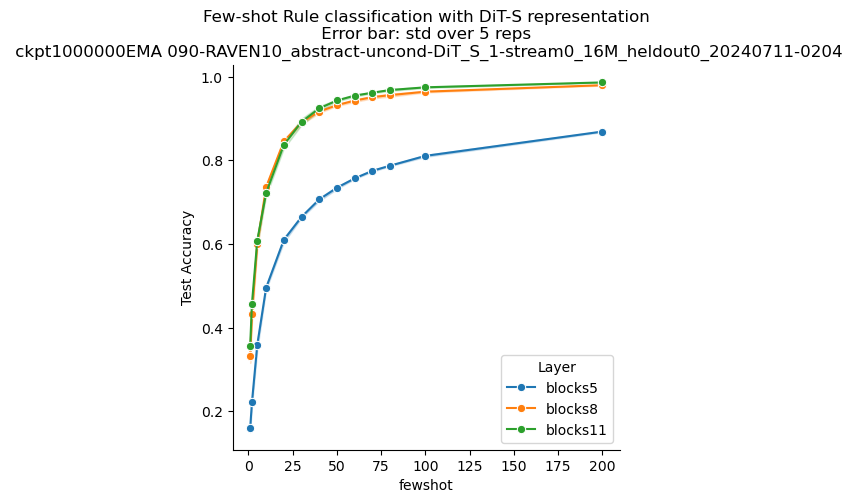

In [51]:
plt.figure(figsize=(5,5))
sns.lineplot(data=syn_df_all, x="fewshot", y="Test Accuracy", hue="Layer", marker="o", errorbar="sd")
plt.title(f"Few-shot Rule classification with DiT-S representation\n Error bar: std over 5 reps \n {ckpt_str} {expname}")
saveallforms(figexpdir, "fewshot_rule_classification_curve_std")

In [55]:
syn_df_all.query("Layer=='blocks11'").groupby("fewshot")["Test Accuracy"].agg(["mean", "std"])

,mean,std
fewshot,,
1,0.356610,0.013373
2,0.457415,0.004626
5,0.608425,0.011631
10,0.722115,0.006822
20,0.836935,0.008270
30,0.892375,0.007665
40,0.924465,0.005671
50,0.943335,0.002550
60,0.954925,0.002456


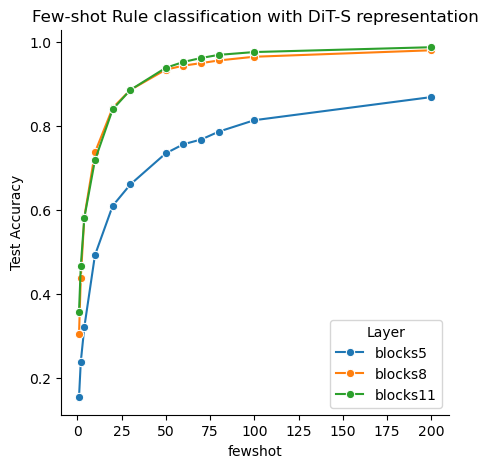

In [33]:
plt.figure(figsize=(5,5))
sns.lineplot(data=syn_df_all, x="fewshot", y="Test Accuracy", hue="Layer", marker="o")
plt.title(f"Few-shot Rule classification with DiT-S representation")
saveallforms(figexpdir, "fewshot_rule_classification_curve")

In [35]:
syn_df_all.query("Layer=='blocks11'")

,Layer,Test Accuracy,Train Accuracy,fewshot,dim red,ckpt,t
2,blocks11,0.358350,1.0,1,avgtoken,ckpt1000000EMA,25
5,blocks11,0.466825,1.0,2,avgtoken,ckpt1000000EMA,25
8,blocks11,0.581975,1.0,4,avgtoken,ckpt1000000EMA,25
11,blocks11,0.718800,1.0,10,avgtoken,ckpt1000000EMA,25
14,blocks11,0.839350,1.0,20,avgtoken,ckpt1000000EMA,25
17,blocks11,0.885725,1.0,30,avgtoken,ckpt1000000EMA,25
20,blocks11,0.938275,1.0,50,avgtoken,ckpt1000000EMA,25
23,blocks11,0.952250,1.0,60,avgtoken,ckpt1000000EMA,25
26,blocks11,0.961675,1.0,70,avgtoken,ckpt1000000EMA,25
29,blocks11,0.969125,1.0,80,avgtoken,ckpt1000000EMA,25


In [22]:
few_samp_num = 5
subsp_mask = th.zeros(40, 3000, dtype=bool)
subsp_mask[:, :few_samp_num] = True
subsp_mask = subsp_mask.flatten()
feature_avg_col_few = {k: v.mean(dim=1)[subsp_mask,:] for k, v in feature_col.items()}
y_train_few = y_train[subsp_mask]

In [23]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col_few, feature_avg_col_test, y_train_few, y_test,
    PC_dim=512, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=1000, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8366, Accuracy: 0.0350
Epoch [1000/5000], Loss: 0.0004, Accuracy: 1.0000
Test Accuracy: 0.3518
Epoch [2000/5000], Loss: 0.0001, Accuracy: 1.0000
Test Accuracy: 0.3547
Epoch [3000/5000], Loss: 0.0001, Accuracy: 1.0000
Test Accuracy: 0.3564
Epoch [4000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3572
Epoch [5000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3584
Test Accuracy: 0.3584
Layer blocks5 - PCA time: 0.00s, PCA transform time: 0.02s, Training time: 2.89s
Processing layer: blocks8
Epoch [1/5000], Loss: 3.8938, Accuracy: 0.0200
Epoch [1000/5000], Loss: 0.0002, Accuracy: 1.0000
Test Accuracy: 0.6013
Epoch [2000/5000], Loss: 0.0001, Accuracy: 1.0000
Test Accuracy: 0.6074
Epoch [3000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.6115
Epoch [4000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.6140
Epoch [5000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.6159
Test Accuracy: 0.6159
Layer blo

### Export for Shane

In [10]:
!ls $STORE_DIR/DL_Projects

alexnet_rearing        GPT2_raven	     mini_edm
convrnn_Evol	       GPT-XL_grad_trace     resnet-sparsemax-model
CorNet-recurrent-evol  HaimDiffusionRNNProj  SiT
DiT		       insilico_exps	     VAR
edm_analy_traj_cmp     LLM_ft
edm_score_validation   Mamba_raven


In [11]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/RPM1000k

aR  attr_all_1000k.npy	attr_all_1000k.pt  attr_seq_tsr_all_1000k.pt


In [12]:
X_test.shape

torch.Size([40000, 3, 9, 9])

In [13]:
list(feature_avg_col)

['blocks5', 'blocks8', 'blocks11']

In [14]:
# ['blocks0', 'blocks2', 'blocks5', 'blocks8', 'blocks11']
feature_last_col_test['blocks11'].shape

torch.Size([40000, 384])

In [16]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data"
# feature_last_col_test
pkl.dump(feature_col_test, open(join(savedir, "feature_all_token_test.pkl"), "wb"))
pkl.dump(feature_avg_col_test, open(join(savedir, "feature_avg_token_test.pkl"), "wb"))
pkl.dump({"X": X_test, "y": y_test}, open(join(savedir, "X_y_test.pkl"), "wb"))

In [20]:
!du -Sh {savedir}/*

14G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data/feature_all_token_test.pkl
172M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data/feature_avg_token_test.pkl
72M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data/X_y_test.pkl


### Label shuffling classifier test

In [22]:
# shuffle y_train and y_test which are torch tensors
y_train_shuffled = y_train.clone()
y_test_shuffled = y_test.clone()
th.manual_seed(0)
y_train_shuffled = y_train[th.randperm(len(y_train))]
y_test_shuffled = y_test[th.randperm(len(y_test))]

In [23]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train_shuffled, y_test_shuffled,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8623, Accuracy: 0.0251
Epoch [250/5000], Loss: 3.6432, Accuracy: 0.0475
Epoch [500/5000], Loss: 3.6381, Accuracy: 0.0485
Epoch [750/5000], Loss: 3.6362, Accuracy: 0.0484
Epoch [1000/5000], Loss: 3.6351, Accuracy: 0.0493
Test Accuracy: 0.0241
Epoch [1250/5000], Loss: 3.6345, Accuracy: 0.0497
Epoch [1500/5000], Loss: 3.6339, Accuracy: 0.0501
Epoch [1750/5000], Loss: 3.6334, Accuracy: 0.0502
Epoch [2000/5000], Loss: 3.6332, Accuracy: 0.0500
Test Accuracy: 0.0241
Epoch [2250/5000], Loss: 3.6328, Accuracy: 0.0500
Epoch [2500/5000], Loss: 3.6325, Accuracy: 0.0499
Epoch [2750/5000], Loss: 3.6323, Accuracy: 0.0501
Epoch [3000/5000], Loss: 3.6320, Accuracy: 0.0502
Test Accuracy: 0.0242
Epoch [3250/5000], Loss: 3.6319, Accuracy: 0.0503
Epoch [3500/5000], Loss: 3.6318, Accuracy: 0.0502
Epoch [3750/5000], Loss: 3.6317, Accuracy: 0.0503
Epoch [4000/5000], Loss: 3.6315, Accuracy: 0.0503
Test Accuracy: 0.0243
Epoch [4250/5000], Loss: 3.6314, Accuracy: